***
# The Blind Machine Taster

**Name:** Michael Nip
<br>
**Net ID:** mpn270

The following report contains my source code as well as written inserts that walk through the methodology and observations. For context, the goal of my project is to create a machine learning pipeline that emulates human identification of wine. This is known as blind tasting, a practice that is frequently used by wine professionals and involves making estimated guesses of a wine's identity based on its observed features alone. To this end, the desired output will be a pipeline that, when provided a description of wine, classifies the given wine's region and grape varietal. This report is segmented into five sections: (1) preprocessing, (2) model training, (3) cross-validation, (4) application & concluding notes, and (5) follow-up analysis, where the first three sections constitute the training process. The data used in this project is the Wine Reviews dataset from Kaggle Open Datasets, which can be found here: https://www.kaggle.com/zynicide/wine-reviews.
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

***
# 1. Preprocessing

## 1.1 Data Treatment

The relevant variables in the data are the fields for description, province, and variety. Description will be used to generate the feature space and province and variety will be used as the labels for the classifers. Once the data is loaded, data records with missing province values are dropped. Since this is a categorical field, there is no way to interpolate the missing values. Additionally, data records with variety values that contain the key word "blend" are dropped since part of this project's goal is to classify the primary grape varietal and not whether or not a wine is a blend of varietals.

In [2]:
data = pd.read_csv('winemag-data_first150k.csv').drop(columns=['Unnamed: 0'])
data = data[(data['province'].notna()) & (data['variety'].str.contains('blend|Blend') == False)]
data

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia
...,...,...,...,...,...,...,...,...,...,...
150911,France,"This needs a good bit of breathing time, then ...",Les Chaliots,87,37.0,Burgundy,Nuits-St.-Georges,NaN,Pinot Noir,Michel Gros
150912,France,The nose is dominated by the attractive scents...,Les Charmes,87,65.0,Burgundy,Chambolle-Musigny,NaN,Pinot Noir,Daniel Rion
150914,US,"Old-gold in color, and thick and syrupy. The a...",Late Harvest Cluster Select,94,25.0,California,Anderson Valley,Mendocino/Lake Counties,White Riesling,Navarro
150922,Italy,Made by 30-ish Roberta Borghese high above Man...,Superiore,91,NaN,Northeastern Italy,Colli Orientali del Friuli,NaN,Tocai,Ronchi di Manzano


## 1.2 TF-IDF Vectorizer

Descriptive words are mined as categorical features from the description field with a TF-IDF vectorizer. This is a popular method for extracting text from a set of documents and in this case, the description value in each data record is treated as a document and the entire set of description values in the dataset is treated as the document set. TF stands for term frequency, which is the number of occurences of a word in a document and IDF stands for inverse document frequency, which is the measure of a word's relative importance based on how common or uncommon it is across a set of documents. 

Taking a single word in a given document as an example, TF is simply the raw count of that word in a document. IDF is calculated is the logarithm of the total number of documents divided by one plus the total number of documents in which that word appears. The one in the denominator ensures that there no zero divisions. Putting the two together, the TF-IDF value is then calculated as TF multiplied by IDF.  

To apply the vectorizer, it is fitted onto the description field, with minimum and maximum document frequency parameters of 0.02 and 0.5, respectfully. These parameters ensure the vectorizer will only learn and calculate the TF-IDF values of words that appear at least 2% and at most 50% of descriptions. A set of stop words are also included as a parameter to the vectorizer, which are a list of words that the vectorizer should ignore under any circumstance. The stop words were initially constructed from the default stop words that come from the Natural Language Toolkit library, which is one of the most popular libraries for natural language processing. It primarly consists of adverbs, propositions, and conjunctions. These stop words were then extended with additional words that were anecdotally flagged as meaningless in the initial fitting of the vectorizer. Finally, the learned vocabulary of the fitted vectorizer is  visualized as a word cloud, where the font size of every word is proportionally correlated with its document frequency. In other words, the larger the word, the more descriptions that word appears in.

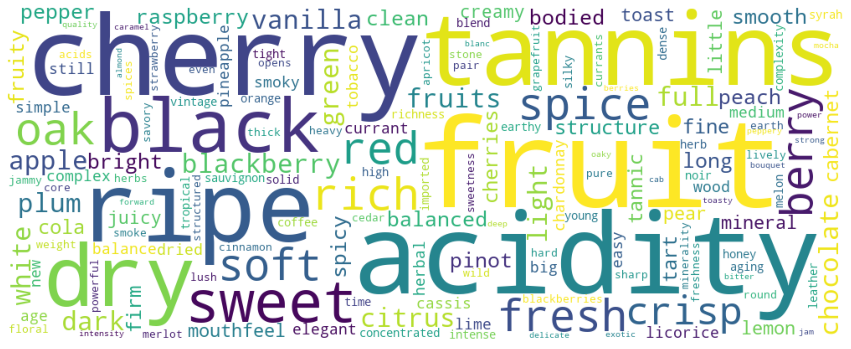

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['alcohol','almost','along','also','although','attractive','aromas','barrel','best','bit','bottle','character','color','come','comes','could','delicious','delivers','drink','drinking','edge','enough','feel','feels','finish','finishes','flavor','followed','give','good','great','hint','hints','like','made','make','makes','mouth','much','needs','next','nice','nicely','nose','note','notes','offers','one','palate','plenty','pretty','price','quite','ready','right','scents','seems','showing','shows','side','slightly','style','tastes','texture','tones','touch','vineyard','way','well','wine','wines','would','year','years','yet'])
vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=0.02, max_df=0.5).fit(data['description'])

names = vectorizer.get_feature_names()
idfs = vectorizer.idf_
freqs = dict([(names[i], 1/idfs[i]) for i in range(len(names))])
wordcloud = WordCloud(width=1000, height=400, min_font_size=7, background_color='white')
plt.figure(figsize=(15,7))
plt.imshow(wordcloud.generate_from_frequencies(freqs))
plt.axis('off')
plt.show()

## 1.3 Principle Component Analysis

The fitted TF-IDF vectorizer from the previous cell is used to transform the description field into sparse vectors of TF-IDF values. Given the size of the TF-IDF matrix, which includes 159 features, principle component analysis (PCA) is used to reduce the this space. To accomplish this, the TF-IDF matrix is first converted into Boolean matrix, where each value is one if the TF-IDF value is greater than zero, otherwise zero. In effect, we end up with 159 columns, each of which take on the value of one or zero, and simulate one-hot encoded features. 

Next, to find the optimal k components for the analysis, a PCA model with the maximum number of components, which is 159 in this case, is fitted and the variance explained by each component is visualized in descending order. As can be observed in the chart, it takes 106 components to explain at least 85% of the variance in the feature space. This value is taken as the optimal k and used to train the final PCA model for later use in reducing the feature space from a 159- to 106-dimensional space.

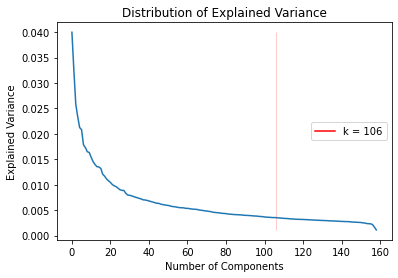

In [8]:
features = np.where(vectorizer.transform(data['description']).todense() > 0, 1, 0)
pca = PCA(random_state=7).fit(features)

dist_variance = pca.explained_variance_ratio_
total_variance, k = 0, 0
for i in range(len(dist_variance)):
    total_variance += dist_variance[i]
    if total_variance >= 0.85:
        k = i
        break

sns.lineplot(x='x', y='y', data=pd.DataFrame({'x':range(len(dist_variance)), 'y':dist_variance}))
sns.lineplot(x='x', 
             y='y', 
             data=pd.DataFrame({'x':[k, k], 'y':[np.min(dist_variance), np.max(dist_variance)]}), 
             color='red',
             label='k = ' + str(k))
plt.title('Distribution of Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.legend(loc='center right')
plt.show()

In [9]:
reducer = PCA(n_components=k, random_state=7).fit(features)

## 1.4 Label Encoder

As the last step in the preprocessing stage, label encoders are used to map the province and grape varietal labels to numerical values. Label encoders are the one-hot encoding equivalent for labels, where each label in a label space is assigned a unique value ranging from zero to one less the total number of labels. Specifically, there are 422 province values that will be mapped to \[0, 1, 2, ..., 421\] and 612 grape varietal labels that will be mapped to \[0, 1, 2, ..., 611\].

In [10]:
y1_encoder = LabelEncoder().fit(data['province'])
y2_encoder = LabelEncoder().fit(data['variety'])

***
# 2. Model Training

## 2.1 Split the Data

Having fitted the necessary preproccessers, the feature space is generated with the TF-IDF vectorizer and PCA reducer and the label space is generated with the province and grape varietal label encoders. These transformed data are then segmented into 70% train data and 30% test data.

In [11]:
x = reducer.transform(features)
y1 = y1_encoder.transform(data['province'])
y2 = y2_encoder.transform(data['variety'])

x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size=0.3, random_state=7)
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size=0.3, random_state=7)

## 2.2 Decision Tree Classifiers

In training the decision tree classifiers, pruning was observed to have a dramatic effect on test accuracy. As shown in the chart, the test accuracy of the decision tree classifier for province sees a steep decline as the minimum number of leaf samples are increased. The same trend exists for the decision tree classifier for grape varietal as well. This is the most likely because of the inevitable loss of variance from the uses of the TF-IDF vectorizer for feature mining and PCA for dimensionality reduction. This lost variance acts as a pseudo-prune in itself since the classifiers are built with a feature set that is already limited. The sheer size of the province and grape varietal label sets may also be contributing factors to this phenomenon as well.

Another observation worth mentioning is that there were no observable differences in test accuracy between the use of Gini and Entropy impurity measures. This falls into the general expectation that there isn't typically significant performance differences between the two measures. As a result of these two observations, the final decision tree classifiers for province and grape varietal are trained with minimal pruning in order to maximize their prediction accuracies.

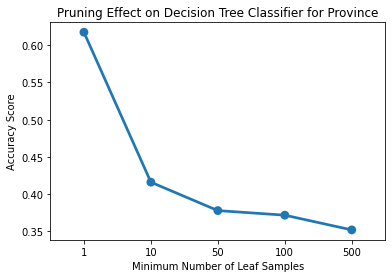

In [12]:
dtc = []
for i in [1,10,50,100,500]:
    dtc.append(DecisionTreeClassifier(min_samples_leaf=i, random_state=7).fit(x_train, y1_train))

sns.pointplot(x='x',
             y='y', 
             data=pd.DataFrame({'x':[1,10,50,100,500], 'y':[dtc[i].score(x_test, y1_test) for i in range(5)]}))
plt.title('Pruning Effect on Decision Tree Classifier for Province')
plt.xlabel('Minimum Number of Leaf Samples')
plt.ylabel('Accuracy Score')
plt.show()

In [13]:
dtc1 = DecisionTreeClassifier(random_state=7).fit(x_train, y1_train)
dtc2 = DecisionTreeClassifier(random_state=7).fit(x_train, y2_train)

## 2.3 Random Forest Classifiers

Since random forest classifiers are an additive extension of decision tree classifiers, the forest estimators were similarly allowed to grow with minimal pruning. The number of estimators for both random forest classifiers were capped at between 20 to 25, which preserved memory consumption while maintaining prediction accuracy. There was no significant improvement in test accuracy when increasing the number of estimators beyond this cap. Further, bootstrap sampling for growing each estimator was enabled and the square root of the total components were considered for determining the split between tree nodes in each estimator. These default specifications were kept as is since deviating from these default specifications had little impact on overall performance.

In [14]:
rfc1 = RandomForestClassifier(n_estimators=25, random_state=7).fit(x_train, y1_train)
rfc2 = RandomForestClassifier(n_estimators=20, random_state=7).fit(x_train, y2_train)

***
# 3. Cross-Validation

The final decision tree and random forest classifiers are cross-validated with test data. All classifiers yielded modest accuracy scores ranging from 60 to nearly 70%. What's more and unsurprisingly, the accuracy scores within classifier variants were identical and there was steady improvement in accuracy between the use of decision tree and random forest classifiers. The former is likely explained by the fact that the same train data, varying only the labels, was used to train the classifiers for both province and grape varietal. The latter is an expected result as the random forest classifer is a strong learner that takes the majority vote of multiple decision tree classifiers. Ultimately, the random forest classifiers produced the most accurate classifications and with negligible additions of computation time given the model specifications. This makes the random forest classifier the winning choice of classifier for this project.

In [15]:
pd.DataFrame({'Classification':['Province','Grape Varietal'],
              'DTC Accuracy':[dtc1.score(x_test, y1_test), dtc2.score(x_test, y2_test)],
              'RFC Accuracy':[rfc1.score(x_test, y1_test), rfc2.score(x_test, y2_test)]})

,Classification,DTC Accuracy,RFC Accuracy
0,Province,0.617461,0.679235
1,Grape Varietal,0.607378,0.669531


***
# 4. Application & Concluding Notes

The goal of this project was to create a machine learning pipeline that, when provided a description of wine, classifies the given wine's region and grape varietal. This very pipeline is created using the fitted preprocessors and random forest classifiers. Its workflow starts with the input, a description of wine; that description is transformed into a sparse vector of features with the TF-IDF vectorizer; the sparse vector is then reduced to k components through principle component analysis; the components are then inputted into the random forest classifiers for province and grape varietal; the numeric outputs of the classifiers are inverse transformed into strings; lastly, the strings are put together to form the output. An example description that demonstrates how this pipeline is used is shown below.

Overall, this pipeline works as planned. However, there are always areas for improvement and it is noteworthy to acknowledge some of those areas here. First, the feature mining can be extended to incorporate n-grams to account for common phrases. For example, wine professionals often use food pairings as a way to describe wine, such as how fish pairs well with certain white wines and red meats with certain red wines. The incorporation of n-grams would enable these common phrases to be captured, making for a more comprehensive feature space. Second, a combination of under- and over-sampling of both the train and test data can be considered for optimal class balancing. Since the data comes from an American wine magazine, there is a heavier concentration of American wines over other types. By making use of under- and over-sampling, the risk of model biases towards American wines would be fully minimized. Lastly, it would be beneficial to expand and diversify the train data by including data not only from one wine magazine, but an array of wine magazines. Since wine magazines typically don't make their content readily available in the form of downloadable data, this would involve additional web scraping.

In [16]:
def classify(description: str) -> str:
    x = reducer.transform(np.where(vectorizer.transform([description]).todense() > 0, 1, 0))
    province = y1_encoder.inverse_transform(rfc1.predict(x))[0]
    variety = y2_encoder.inverse_transform(rfc2.predict(x))[0]
    return 'The province or state is %s and the grape varietal is %s.' % (province, variety)

classify('As the wine is poured, the aromas of strawberries, raspberries, dark summer fruits and a hint of black pepper rise from the glass. These fruit aromas travel onto the flavor, where they merge with vanilla and oak derived from aging the wine in French oak cask.')

'The province or state is Washington and the grape varietal is Cabernet Sauvignon.'

***
# 5. Follow-up Analysis

During the final presentation of this project, the use of 159 features to classify 422 provinces and 612 grape varietals was flagged as an area for further refinement. The solution for this was to reduce the size of the classification problem such that there was a more balanced ratio of features to labels. Since there are hundreds of grape varietals, even for a single province, the problem was redefined in this follow-up analysis to utilize the 159 features to classify only the province and this time, limiting the scope to the US. There are at most, 50 states in the US, which makes for a healthy ratio of features to labels.

For a sensible comparison, the original data was limited to US observations with the country field and the same preprocessing steps were reapplied; then, the transformed data was again, split into 70% train data and 30% test data and both decision tree and random forest classifiers were trained as before with minimal pruning. Both classifiers were finally cross-validated with the test data. 

The results of the cross-validation show significant improvement in  prediction accuracy from that of the original models, with accuracy scores ranging from 80 to nearly 90%. This is a positive outcome that validates the motivation for this follow-up analysis as well as expectations. Since the complexities of the preprocessing and model training were kept constant while the problem size was reduced, this improvement in performance was expected. These results also give rise to a greater weight on the importance of a previously mentioned concluding note. That is, in the context of wine classification, it is important to ensure that the feature mining process of wine descriptions not only produce descriptive features, but a sufficient breadth of features that would form a feature space large enough to accomodate the expansive label space of wine identities. One way that this can be accomplished is by incorporating n-grams of varying sizes into the process.

In [17]:
data_us = data[data['country'] == 'US']

x = reducer.transform(np.where(vectorizer.transform(data_us['description']).todense() > 0, 1, 0))
y = y1_encoder.transform(data_us['province'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

dtc = DecisionTreeClassifier(random_state=7).fit(x_train, y_train)
rfc = RandomForestClassifier(n_estimators=15, random_state=7).fit(x_train, y_train)

pd.DataFrame({'Classification':['State'],
              'DTC Accuracy':[dtc.score(x_test, y_test)],
              'RFC Accuracy':[rfc.score(x_test, y_test)]})

,Classification,DTC Accuracy,RFC Accuracy
0,State,0.816353,0.864985
